In [38]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as patches
from scipy import signal
import peakutils
import math
from cmcrameri import cm


In [4]:
experiment_name = 'P3856'
run_name = 'P3856_YHE211_1_Slot1-1_1_5104'
precursor_definition_method = 'pasef'
experiment_base_dir = '/media/big-ssd/experiments'
experiment_dir = "{}/{}".format(experiment_base_dir, experiment_name)
converted_db_name = "{}/converted-databases/exp-{}-run-{}-converted.sqlite".format(experiment_dir, experiment_name, run_name)

In [5]:
# frame types for PASEF mode
FRAME_TYPE_MS1 = 0
FRAME_TYPE_MS2 = 8

In [6]:
mz_lower = 700
mz_upper = 720
rt_lower = 1620
rt_upper = 1680

In [7]:
# load the frames
db_conn = sqlite3.connect(converted_db_name)
raw_points_df = pd.read_sql_query("select frame_id,mz,scan,intensity,retention_time_secs from frames where frame_type == {} and retention_time_secs >= {} and retention_time_secs <= {} and mz >= {} and mz <= {}".format(FRAME_TYPE_MS1, rt_lower, rt_upper, mz_lower, mz_upper), db_conn)
db_conn.close()

In [15]:
RT_BIN_SIZE = 10
SCAN_BIN_SIZE = 50
MZ_BIN_SIZE = 5

In [22]:
rt_bins = pd.interval_range(start=0.0, end=5000.0, freq=RT_BIN_SIZE)
scan_bins = pd.interval_range(start=0, end=1000, freq=SCAN_BIN_SIZE)
mz_bins = pd.interval_range(start=100.0, end=1700.0, freq=MZ_BIN_SIZE)


In [23]:
raw_points_df['rt_bin'] = pd.cut(raw_points_df.retention_time_secs, bins=rt_bins)
raw_points_df['scan_bin'] = pd.cut(raw_points_df.scan, bins=scan_bins)
raw_points_df['mz_bin'] = pd.cut(raw_points_df.mz, bins=mz_bins)

In [24]:
raw_points_df.sample(n=5)

,frame_id,mz,scan,intensity,retention_time_secs,rt_bin,scan_bin,mz_bin
478005,14552,704.359369,133,175,1644.094274,"(1640.0, 1650.0]","(100, 150]","(700.0, 705.0]"
920105,14762,717.312793,142,9,1666.321024,"(1660.0, 1670.0]","(100, 150]","(715.0, 720.0]"
953562,14777,708.469249,133,10,1667.908146,"(1660.0, 1670.0]","(100, 150]","(705.0, 710.0]"
810608,14707,708.394114,637,87,1660.500328,"(1660.0, 1670.0]","(600, 650]","(705.0, 710.0]"
204857,14417,710.357288,90,51,1629.801086,"(1620.0, 1630.0]","(50, 100]","(710.0, 715.0]"


In [32]:
summary_df = raw_points_df.groupby(['mz_bin','scan_bin','rt_bin'], as_index=False, sort=False).intensity.sum()

In [33]:
summary_df.dropna(subset = ['intensity'], inplace=True)

In [35]:
summary_df.sort_values(by=['intensity'], ascending=False, inplace=True)

In [37]:
summary_df.head(n=10)

,mz_bin,scan_bin,rt_bin,intensity
16503,"(705.0, 710.0]","(650, 700]","(1650.0, 1660.0]",1951675.0
36505,"(715.0, 720.0]","(650, 700]","(1670.0, 1680.0]",1640770.0
31502,"(715.0, 720.0]","(150, 200]","(1640.0, 1650.0]",1380722.0
5500,"(700.0, 705.0]","(550, 600]","(1620.0, 1630.0]",1258639.0
31002,"(715.0, 720.0]","(100, 150]","(1640.0, 1650.0]",1248004.0
6500,"(700.0, 705.0]","(650, 700]","(1620.0, 1630.0]",1196985.0
31005,"(715.0, 720.0]","(100, 150]","(1670.0, 1680.0]",1118425.0
6504,"(700.0, 705.0]","(650, 700]","(1660.0, 1670.0]",1117013.0
2003,"(700.0, 705.0]","(200, 250]","(1650.0, 1660.0]",1005030.0
1001,"(700.0, 705.0]","(100, 150]","(1630.0, 1640.0]",930533.0


In [39]:
# create the colour map to convert intensity to colour
colour_map = cm.batlow_r
norm = colors.LogNorm(vmin=100, vmax=1000, clip=True)

In [46]:
aoi_s = summary_df.iloc[0]
mz_lower = aoi_s.mz_bin.left
mz_upper = aoi_s.mz_bin.right
scan_lower = aoi_s.scan_bin.left
scan_upper = aoi_s.scan_bin.right
rt_lower = aoi_s.rt_bin.mid-0.5
rt_upper = aoi_s.rt_bin.mid+0.5

In [47]:
aoi_df = raw_points_df[(raw_points_df.mz >= mz_lower) & (raw_points_df.mz <= mz_upper) & (raw_points_df.scan >= scan_lower) & (raw_points_df.scan <= scan_upper) & (raw_points_df.retention_time_secs >= rt_lower) & (raw_points_df.retention_time_secs <= rt_upper)]


In [49]:
anchor_point_s = aoi_df.loc[aoi_df.intensity.idxmax()]

In [50]:
anchor_point_s

frame_id                          14652
mz                              705.846
scan                                651
intensity                           479
retention_time_secs             1654.68
rt_bin                 (1650.0, 1660.0]
scan_bin                     (650, 700]
mz_bin                   (705.0, 710.0]
Name: 695919, dtype: object

In [55]:
ANCHOR_POINT_MZ_LOWER_OFFSET = 0.6   # one isotope for charge-2 plus a little bit more
ANCHOR_POINT_MZ_UPPER_OFFSET = 3.0   # six isotopes for charge-2 plus a little bit more

ANCHOR_POINT_SCAN_LOWER_OFFSET = 100
ANCHOR_POINT_SCAN_UPPER_OFFSET = 100

In [56]:
mz_lower = anchor_point_s.mz - ANCHOR_POINT_MZ_LOWER_OFFSET
mz_upper = anchor_point_s.mz + ANCHOR_POINT_MZ_UPPER_OFFSET
scan_lower = anchor_point_s.scan - ANCHOR_POINT_SCAN_LOWER_OFFSET
scan_upper = anchor_point_s.scan + ANCHOR_POINT_SCAN_UPPER_OFFSET

In [59]:
anchor_frame_df = raw_points_df[(raw_points_df.frame_id == anchor_point_s.frame_id) & (raw_points_df.mz >= mz_lower) & (raw_points_df.mz <= mz_upper) & (raw_points_df.scan >= scan_lower) & (raw_points_df.scan <= scan_upper)]


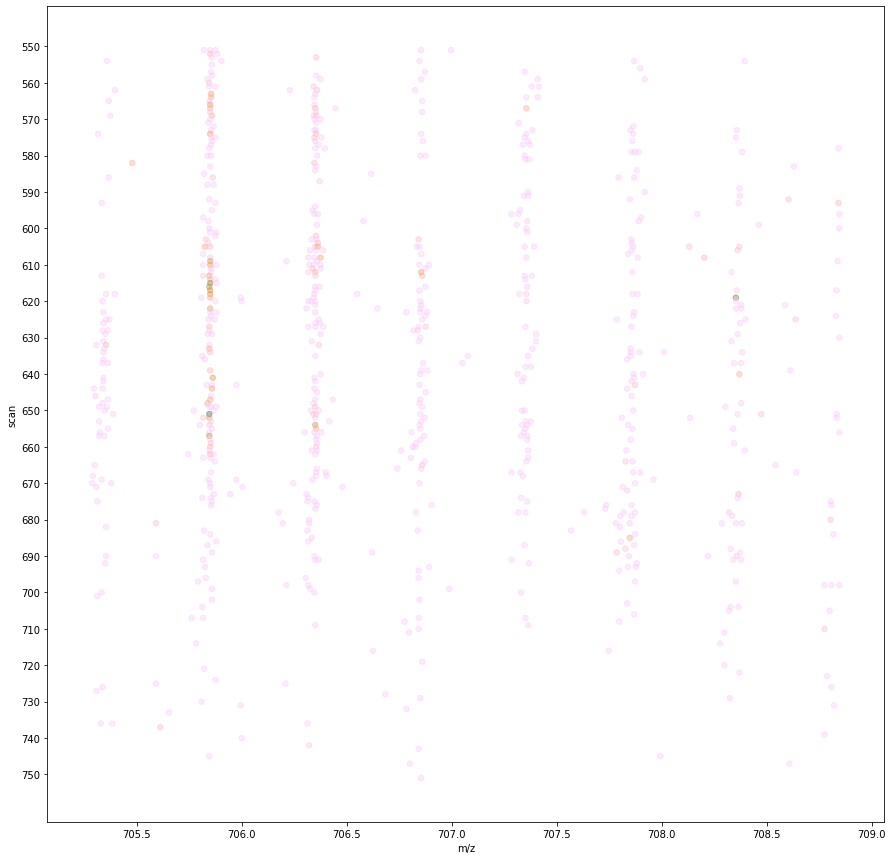

In [60]:
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(anchor_frame_df.mz, anchor_frame_df.scan, c=anchor_frame_df.intensity, cmap=colour_map, norm=norm, alpha=0.4, s=30, linewidths=None, edgecolors=None)

plt.xlabel("m/z")
plt.ylabel("scan")

nearest = 0.5
range_l = round(anchor_frame_df.mz.min() / nearest) * nearest
range_u = round(anchor_frame_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

nearest = 10.0
range_l = round(anchor_frame_df.scan.min() / nearest) * nearest
range_u = round(anchor_frame_df.scan.max() / nearest) * nearest
plt.yticks(np.arange(range_l,range_u+nearest,nearest))

plt.gca().invert_yaxis()
plt.show()